In [6]:
import os
import sqlite3
import pickle
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from kiwipiepy import Kiwi
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

BASE_DIR = os.path.join('..')
DATA_DIR = os.path.join(BASE_DIR, 'data_final')
DB_DIR = os.path.join(BASE_DIR, 'database_final')

REG_PATH = os.path.join(DATA_DIR, 'regression_dataset_v2.csv')
SAMPLED_DATA_PATH = os.path.join(DATA_DIR, 'sampled_data_v2.pkl')
QUERIES_PATH = os.path.join(BASE_DIR, 'data', 'queries.pkl')
QRELS_PATH = os.path.join(BASE_DIR, 'data', 'qrels.pkl')
DB_PATH = os.path.join(DB_DIR, 'search_index_v2.db')

print("데이터 로드")
df_reg = pd.read_csv(REG_PATH)
df = pd.read_pickle(SAMPLED_DATA_PATH)

if '_id' in df.columns:
    df.set_index('_id', inplace=True)
elif 'doc_id' in df.columns:
    df.set_index('doc_id', inplace=True)
df.index = df.index.astype(str)

with open(QUERIES_PATH, 'rb') as f:
    queries_data = pickle.load(f)
with open(QRELS_PATH, 'rb') as f:
    qrels_data = pickle.load(f)

qrels_dict = {}
for item in qrels_data:
    qid, doc_id = str(item.get('query-id')), str(item.get('corpus-id'))
    if qid and doc_id:
        qrels_dict.setdefault(qid, set()).add(doc_id)

queries_map = {str(q['_id']): q['text'] for q in queries_data if '_id' in q}

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

cursor.execute('SELECT term, COUNT(DISTINCT doc_id) FROM inverted_index GROUP BY term')
doc_freq = {term: df_count for term, df_count in cursor.fetchall()}

total_docs = len(df)
avg_dl = df['doc_length'].mean()
idf_cache = {t: math.log((total_docs - df_count + 0.5) / (df_count + 0.5) + 1)
             for t, df_count in doc_freq.items()}

kiwi = Kiwi(num_workers=0)

print(f"회귀 데이터셋: {len(df_reg)}개")
print(f"문서 데이터셋: {len(df)}개")

def tokenize_query(text):
    try:
        return [t.form for t in kiwi.tokenize(text) if t.tag in ['NNG', 'NNP', 'VV', 'VA', 'MAG']]
    except:
        return []

def calculate_scores(query_tokens, model_type='BM25', k1=1.2, b=0.75):
    scores = {}
    for term in query_tokens:
        if term not in idf_cache:
            continue
        idf = idf_cache[term]

        cursor.execute('SELECT doc_id, tf FROM inverted_index WHERE term = ?', (term,))
        rows = cursor.fetchall()

        for doc_id, tf in rows:
            if model_type == 'BIM':
                scores[doc_id] = scores.get(doc_id, 0.0) + idf
            else:
                doc_len = df.at[doc_id, 'doc_length']
                num = tf * (k1 + 1)
                den = tf + k1 * (1 - b + b * (doc_len / avg_dl))
                scores[doc_id] = scores.get(doc_id, 0.0) + idf * (num / den)
    return scores

def calculate_metrics(ranked_docs, relevant_docs, k=10):
    top_k = ranked_docs[:k]
    relevant_retrieved_k = len(set(top_k) & relevant_docs)
    p_at_k = relevant_retrieved_k / k

    total_relevant = len(relevant_docs)
    r_at_k = relevant_retrieved_k / total_relevant if total_relevant > 0 else 0

    relevant_count = 0
    precision_sum = 0.0
    for i, doc_id in enumerate(ranked_docs):
        if doc_id in relevant_docs:
            relevant_count += 1
            precision_sum += relevant_count / (i + 1)

    ap = precision_sum / total_relevant if total_relevant > 0 else 0
    return p_at_k, r_at_k, ap

processed_queries = {}
for qid in qrels_dict:
    if qid in queries_map:
        tokens = tokenize_query(queries_map[qid])
        if tokens:
            processed_queries[qid] = tokens

print(f"쿼리 수: {len(processed_queries)}개")

df_reg['doc_length_scaled'] = df_reg['doc_length'] / 1000
df_reg['query_length_scaled'] = df_reg['query_length']

df['length_category'] = pd.qcut(
    df['morph_count'],
    q=3,
    labels=['Short', 'Medium', 'Long']
)

df['complexity_category'] = pd.qcut(
    df['avg_sent_len'],
    q=3,
    labels=['Simple', 'Medium', 'Complex']
)

def run_multinomial_regression(model_name, subset_df):
    scaler = StandardScaler()
    X_vals = subset_df[['doc_length', 'query_length']].values
    X_scaled = scaler.fit_transform(X_vals)
    X = pd.DataFrame(X_scaled, columns=['doc_length_scaled', 'query_length_scaled'], index=subset_df.index)

    y = subset_df['dominant_topic'].astype(int)

    X = sm.add_constant(X)
    X = X.astype(float)

    try:
        model = sm.MNLogit(y, X)
        result = model.fit(method='bfgs', disp=0, maxiter=1000)

        all_results = []
        for outcome_idx in range(len(result.params)):
            params = result.params.iloc[outcome_idx]
            pvalues = result.pvalues.iloc[outcome_idx]
            conf_int = result.conf_int().iloc[outcome_idx*len(params):(outcome_idx+1)*len(params)]

            df_res = pd.DataFrame({
                'Model': model_name,
                'Outcome': outcome_idx,
                'Feature': params.index,
                'Coefficient': params.values,
                'Odds_Ratio': np.exp(params.values),
                'P_value': pvalues.values,
                'Lower_CI': np.exp(conf_int.iloc[:, 0].values),
                'Upper_CI': np.exp(conf_int.iloc[:, 1].values)
            })
            all_results.append(df_res)

        df_combined = pd.concat(all_results, ignore_index=True)
        pseudo_r2 = 1 - (result.llf / result.llnull)
        aic = result.aic

        return df_combined, pseudo_r2, aic
    except Exception as e:
        print(f"Error in {model_name}: {e}")
        return pd.DataFrame(), 0, 0

models_to_run = [
    {'name': 'BIM', 'type': 'BIM', 'k1': 0, 'b': 0},
    {'name': 'BM25_Best', 'type': 'BM25', 'k1': 3.25, 'b': 0.99}
]

print("\n[Step 1: 길이별 분석]")

df_reg['length_category'] = pd.qcut(
    df_reg['doc_length'],
    q=3,
    labels=['Short', 'Medium', 'Long']
)

print(f"\n길이 카테고리 분포")
length_dist = df['length_category'].value_counts().sort_index()
for cat, count in length_dist.items():
    print(f"{cat}: {count}개 ({count/len(df)*100:.1f}%)")

length_odds_results = []
length_performance = []

for category in ['Short', 'Medium', 'Long']:
    print(f"\n{category} 카테고리")

    category_docs = set(df[df['length_category'] == category].index)
    reg_subset = df_reg[df_reg['length_category'] == category]

    for model_info in models_to_run:
        model_name = model_info['name']
        print(f"  {model_name} Multinomial 로지스틱 회귀")

        model_reg_subset = reg_subset[reg_subset['model'] == ('BIM' if model_name == 'BIM' else 'BM25_Best')]

        if len(model_reg_subset) > 0 and len(model_reg_subset['dominant_topic'].unique()) > 1:
            odds_df, r2, aic = run_multinomial_regression(f"{model_name}_{category}", model_reg_subset)
            odds_df['category'] = category
            length_odds_results.append(odds_df)
            print(f"    Pseudo R2: {r2:.4f}, AIC: {aic:.2f}")

        print(f"  {model_name} 성능 평가")

        total_map = 0
        total_p10 = 0
        total_r10 = 0
        count = 0

        for qid, q_tokens in tqdm(processed_queries.items(), desc=f"{model_name}-{category}", leave=False):
            target_docs = qrels_dict[qid]
            relevant_in_category = target_docs & category_docs

            if not relevant_in_category:
                continue

            scores = calculate_scores(q_tokens, model_type=model_info['type'],
                                      k1=model_info['k1'], b=model_info['b'])

            ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            ranked_ids = [d for d, s in ranked[:100] if d in category_docs]

            p10, r10, ap = calculate_metrics(ranked_ids, relevant_in_category, k=10)

            total_map += ap
            total_p10 += p10
            total_r10 += r10
            count += 1

        avg_map = total_map / count if count > 0 else 0
        avg_p10 = total_p10 / count if count > 0 else 0
        avg_r10 = total_r10 / count if count > 0 else 0

        print(f"    MAP: {avg_map:.4f}, P@10: {avg_p10:.4f}, R@10: {avg_r10:.4f} (쿼리: {count}개)")

        length_performance.append({
            'category': category,
            'model': model_name,
            'MAP': avg_map,
            'P@10': avg_p10,
            'R@10': avg_r10,
            'query_count': count
        })

df_length_odds = pd.concat(length_odds_results, ignore_index=True) if length_odds_results else pd.DataFrame()
df_length_perf = pd.DataFrame(length_performance)

print("\n[Step 2: 토픽별 분석]")

topic_odds_results = []
topic_performance = []

for topic_id in range(10):
    print(f"\nTopic {topic_id}")

    topic_docs = set(df[df['dominant_topic'] == topic_id].index)
    reg_subset = df_reg[df_reg['dominant_topic'] == topic_id]

    for model_info in models_to_run:
        model_name = model_info['name']
        print(f"  {model_name} Multinomial 로지스틱 회귀")

        model_reg_subset = reg_subset[reg_subset['model'] == ('BIM' if model_name == 'BIM' else 'BM25_Best')]

        if len(model_reg_subset) > 0:
            print(f"    Skip (단일 토픽 데이터)")

        print(f"  {model_name} 성능 평가")

        total_map = 0
        total_p10 = 0
        total_r10 = 0
        count = 0

        for qid, q_tokens in tqdm(processed_queries.items(), desc=f"{model_name}-T{topic_id}", leave=False):
            target_docs = qrels_dict[qid]
            relevant_in_topic = target_docs & topic_docs

            if not relevant_in_topic:
                continue

            scores = calculate_scores(q_tokens, model_type=model_info['type'],
                                      k1=model_info['k1'], b=model_info['b'])

            ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            ranked_ids = [d for d, s in ranked[:100] if d in topic_docs]

            p10, r10, ap = calculate_metrics(ranked_ids, relevant_in_topic, k=10)

            total_map += ap
            total_p10 += p10
            total_r10 += r10
            count += 1

        avg_map = total_map / count if count > 0 else 0
        avg_p10 = total_p10 / count if count > 0 else 0
        avg_r10 = total_r10 / count if count > 0 else 0

        print(f"    MAP: {avg_map:.4f}, P@10: {avg_p10:.4f}, R@10: {avg_r10:.4f} (쿼리: {count}개)")

        topic_performance.append({
            'topic': topic_id,
            'model': model_name,
            'MAP': avg_map,
            'P@10': avg_p10,
            'R@10': avg_r10,
            'query_count': count,
            'doc_count': len(topic_docs)
        })

df_topic_perf = pd.DataFrame(topic_performance)

print("\n[Step 3: 복잡도별 분석]")

df_reg['complexity_category'] = pd.qcut(
    df_reg['doc_length'] / df_reg['doc_length'].max() * 100,
    q=3,
    labels=['Simple', 'Medium', 'Complex']
)

print(f"\n복잡도 카테고리 분포")
complexity_dist = df['complexity_category'].value_counts().sort_index()
for cat, count in complexity_dist.items():
    print(f"{cat}: {count}개 ({count/len(df)*100:.1f}%)")

complexity_odds_results = []
complexity_performance = []

for complexity in ['Simple', 'Medium', 'Complex']:
    print(f"\n{complexity} 카테고리")

    complexity_docs = set(df[df['complexity_category'] == complexity].index)
    reg_subset = df_reg[df_reg['complexity_category'] == complexity]

    for model_info in models_to_run:
        model_name = model_info['name']
        print(f"  {model_name} Multinomial 로지스틱 회귀")

        model_reg_subset = reg_subset[reg_subset['model'] == ('BIM' if model_name == 'BIM' else 'BM25_Best')]

        if len(model_reg_subset) > 0 and len(model_reg_subset['dominant_topic'].unique()) > 1:
            odds_df, r2, aic = run_multinomial_regression(f"{model_name}_{complexity}", model_reg_subset)
            odds_df['complexity'] = complexity
            complexity_odds_results.append(odds_df)
            print(f"    Pseudo R2: {r2:.4f}, AIC: {aic:.2f}")

        print(f"  {model_name} 성능 평가")

        total_map = 0
        total_p10 = 0
        total_r10 = 0
        count = 0

        for qid, q_tokens in tqdm(processed_queries.items(), desc=f"{model_name}-{complexity}", leave=False):
            target_docs = qrels_dict[qid]
            relevant_in_complexity = target_docs & complexity_docs

            if not relevant_in_complexity:
                continue

            scores = calculate_scores(q_tokens, model_type=model_info['type'],
                                      k1=model_info['k1'], b=model_info['b'])

            ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            ranked_ids = [d for d, s in ranked[:100] if d in complexity_docs]

            p10, r10, ap = calculate_metrics(ranked_ids, relevant_in_complexity, k=10)

            total_map += ap
            total_p10 += p10
            total_r10 += r10
            count += 1

        avg_map = total_map / count if count > 0 else 0
        avg_p10 = total_p10 / count if count > 0 else 0
        avg_r10 = total_r10 / count if count > 0 else 0

        print(f"    MAP: {avg_map:.4f}, P@10: {avg_p10:.4f}, R@10: {avg_r10:.4f} (쿼리: {count}개)")

        complexity_performance.append({
            'complexity': complexity,
            'model': model_name,
            'MAP': avg_map,
            'P@10': avg_p10,
            'R@10': avg_r10,
            'query_count': count
        })

df_complexity_odds = pd.concat(complexity_odds_results, ignore_index=True) if complexity_odds_results else pd.DataFrame()
df_complexity_perf = pd.DataFrame(complexity_performance)

conn.close()

print("\n[Step 4: 결과 저장]")
if not df_length_odds.empty:
    df_length_odds.to_csv(os.path.join(DATA_DIR, 'length_odds_ratio_v3.csv'), index=False)
df_length_perf.to_csv(os.path.join(DATA_DIR, 'length_performance_v3.csv'), index=False)
df_topic_perf.to_csv(os.path.join(DATA_DIR, 'topic_performance_v3.csv'), index=False)
if not df_complexity_odds.empty:
    df_complexity_odds.to_csv(os.path.join(DATA_DIR, 'complexity_odds_ratio_v3.csv'), index=False)
df_complexity_perf.to_csv(os.path.join(DATA_DIR, 'complexity_performance_v3.csv'), index=False)

print("\n[Step 5: 요약 통계]")
print("\n길이별 성능 요약 (MAP)")
print(df_length_perf.pivot_table(index='category', columns='model', values='MAP'))

print("\n토픽별 성능 요약 (MAP)")
print(df_topic_perf.pivot_table(index='topic', columns='model', values='MAP'))

print("\n복잡도별 성능 요약 (MAP)")
print(df_complexity_perf.pivot_table(index='complexity', columns='model', values='MAP'))

df_length = df_length_perf
df_topic = df_topic_perf
df_complexity = df_complexity_perf

데이터 로드
회귀 데이터셋: 27298개
문서 데이터셋: 5000개
쿼리 수: 1454개

[Step 1: 길이별 분석]

길이 카테고리 분포
Short: 1669개 (33.4%)
Medium: 1664개 (33.3%)
Long: 1667개 (33.3%)

Short 카테고리
  BIM Multinomial 로지스틱 회귀
    Pseudo R2: 0.0142, AIC: 7138.94
  BIM 성능 평가


    MAP: 0.6457, P@10: 0.1381, R@10: 0.6998 (쿼리: 775개)
  BM25_Best Multinomial 로지스틱 회귀
    Pseudo R2: 0.0128, AIC: 31443.43
  BM25_Best 성능 평가


    MAP: 0.7398, P@10: 0.1646, R@10: 0.8249 (쿼리: 775개)

Medium 카테고리
  BIM Multinomial 로지스틱 회귀
    Pseudo R2: 0.0050, AIC: 19915.42
  BIM 성능 평가


    MAP: 0.6403, P@10: 0.1548, R@10: 0.7603 (쿼리: 786개)
  BM25_Best Multinomial 로지스틱 회귀
    Pseudo R2: 0.0050, AIC: 20839.79
  BM25_Best 성능 평가


    MAP: 0.7571, P@10: 0.1728, R@10: 0.8401 (쿼리: 786개)

Long 카테고리
  BIM Multinomial 로지스틱 회귀
    Pseudo R2: 0.0302, AIC: 32605.25
  BIM 성능 평가


    MAP: 0.5927, P@10: 0.1461, R@10: 0.7701 (쿼리: 866개)
  BM25_Best Multinomial 로지스틱 회귀
    Pseudo R2: 0.0111, AIC: 7077.13
  BM25_Best 성능 평가


    MAP: 0.8239, P@10: 0.1759, R@10: 0.9124 (쿼리: 866개)

[Step 2: 토픽별 분석]

Topic 0
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.5365, P@10: 0.1482, R@10: 0.6571 (쿼리: 280개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.7431, P@10: 0.1882, R@10: 0.8211 (쿼리: 280개)

Topic 1
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.5411, P@10: 0.1462, R@10: 0.6943 (쿼리: 357개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.7111, P@10: 0.1717, R@10: 0.7897 (쿼리: 357개)

Topic 2
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.3307, P@10: 0.1527, R@10: 0.4842 (쿼리: 93개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.6365, P@10: 0.2527, R@10: 0.7943 (쿼리: 93개)

Topic 3
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.6003, P@10: 0.1691, R@10: 0.7039 (쿼리: 165개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.8020, P@10: 0.2097, R@10: 0.8489 (쿼리: 165개)

Topic 4
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.5687, P@10: 0.1784, R@10: 0.7503 (쿼리: 185개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.7981, P@10: 0.2086, R@10: 0.8668 (쿼리: 185개)

Topic 5
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.5330, P@10: 0.1464, R@10: 0.6678 (쿼리: 332개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.7284, P@10: 0.1934, R@10: 0.8115 (쿼리: 332개)

Topic 6
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.6179, P@10: 0.1838, R@10: 0.7429 (쿼리: 198개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.8143, P@10: 0.2192, R@10: 0.8830 (쿼리: 198개)

Topic 7
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.5618, P@10: 0.1831, R@10: 0.7309 (쿼리: 77개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.8000, P@10: 0.2312, R@10: 0.8942 (쿼리: 77개)

Topic 8
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.5003, P@10: 0.1581, R@10: 0.6616 (쿼리: 215개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.7599, P@10: 0.2033, R@10: 0.8334 (쿼리: 215개)

Topic 9
  BIM Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BIM 성능 평가


    MAP: 0.6166, P@10: 0.1972, R@10: 0.7687 (쿼리: 108개)
  BM25_Best Multinomial 로지스틱 회귀
    Skip (단일 토픽 데이터)
  BM25_Best 성능 평가


    MAP: 0.8066, P@10: 0.2241, R@10: 0.8804 (쿼리: 108개)

[Step 3: 복잡도별 분석]

복잡도 카테고리 분포
Simple: 1667개 (33.3%)
Medium: 1666개 (33.3%)
Complex: 1667개 (33.3%)

Simple 카테고리
  BIM Multinomial 로지스틱 회귀
    Pseudo R2: 0.0142, AIC: 7138.94
  BIM 성능 평가


    MAP: 0.5513, P@10: 0.1271, R@10: 0.6984 (쿼리: 835개)
  BM25_Best Multinomial 로지스틱 회귀
    Pseudo R2: 0.0128, AIC: 31443.43
  BM25_Best 성능 평가


    MAP: 0.7430, P@10: 0.1563, R@10: 0.8325 (쿼리: 835개)

Medium 카테고리
  BIM Multinomial 로지스틱 회귀
    Pseudo R2: 0.0050, AIC: 19915.42
  BIM 성능 평가


    MAP: 0.5605, P@10: 0.1319, R@10: 0.7115 (쿼리: 867개)
  BM25_Best Multinomial 로지스틱 회귀
    Pseudo R2: 0.0050, AIC: 20839.79
  BM25_Best 성능 평가


    MAP: 0.7765, P@10: 0.1640, R@10: 0.8608 (쿼리: 867개)

Complex 카테고리
  BIM Multinomial 로지스틱 회귀
    Pseudo R2: 0.0302, AIC: 32605.25
  BIM 성능 평가


    MAP: 0.5137, P@10: 0.1470, R@10: 0.6823 (쿼리: 759개)
  BM25_Best Multinomial 로지스틱 회귀
    Pseudo R2: 0.0111, AIC: 7077.13
  BM25_Best 성능 평가


    MAP: 0.7640, P@10: 0.1879, R@10: 0.8523 (쿼리: 759개)

[Step 4: 결과 저장]

[Step 5: 요약 통계]

길이별 성능 요약 (MAP)
model          BIM  BM25_Best
category                     
Long      0.592711   0.823939
Medium    0.640311   0.757110
Short     0.645748   0.739834

토픽별 성능 요약 (MAP)
model       BIM  BM25_Best
topic                     
0      0.536468   0.743077
1      0.541091   0.711131
2      0.330678   0.636476
3      0.600286   0.801964
4      0.568741   0.798081
5      0.533005   0.728361
6      0.617906   0.814300
7      0.561794   0.799971
8      0.500288   0.759863
9      0.616608   0.806576

복잡도별 성능 요약 (MAP)
model            BIM  BM25_Best
complexity                     
Complex     0.513660   0.763999
Medium      0.560490   0.776506
Simple      0.551315   0.743028



[시각화 생성]


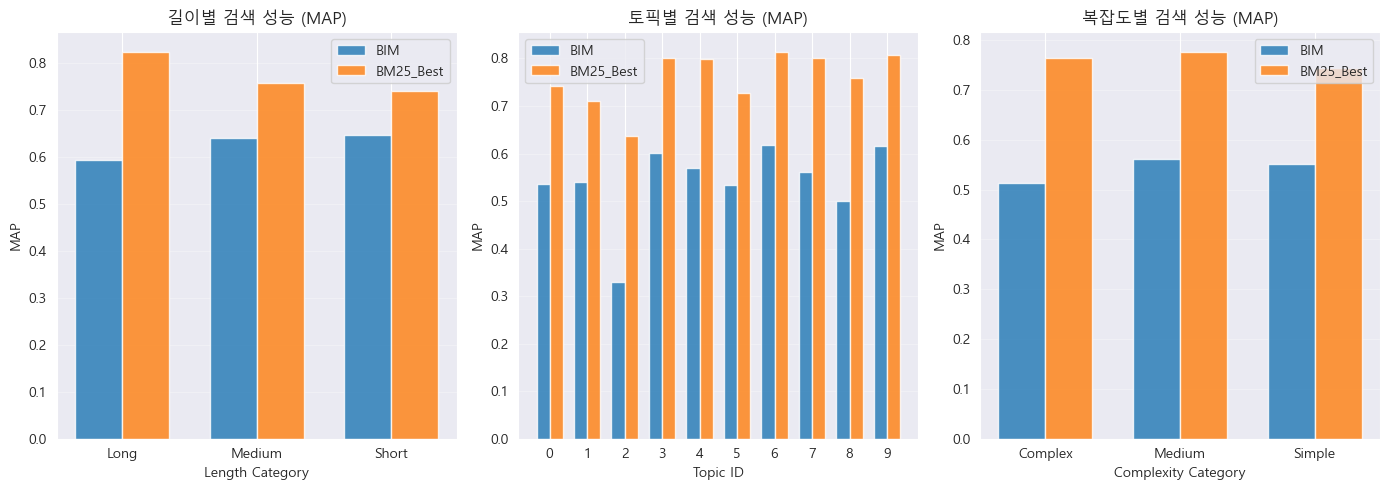

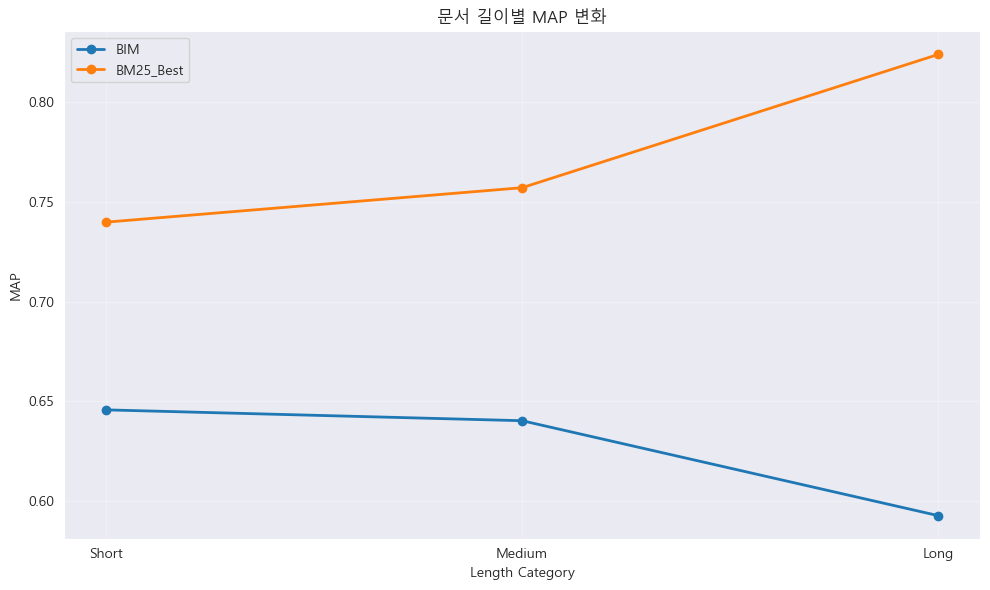

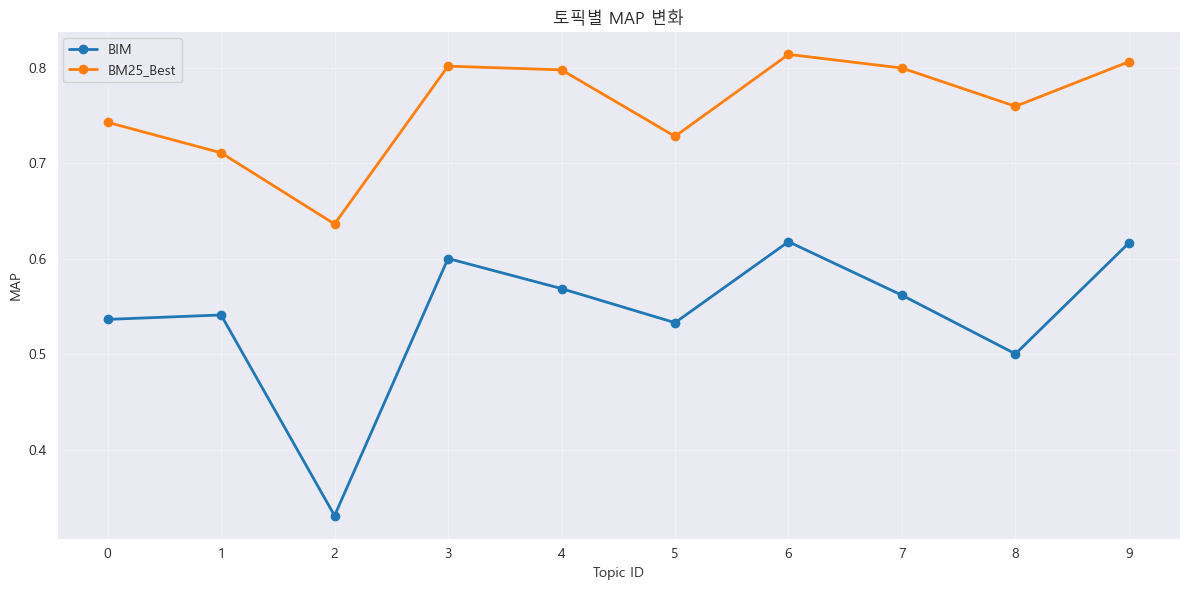

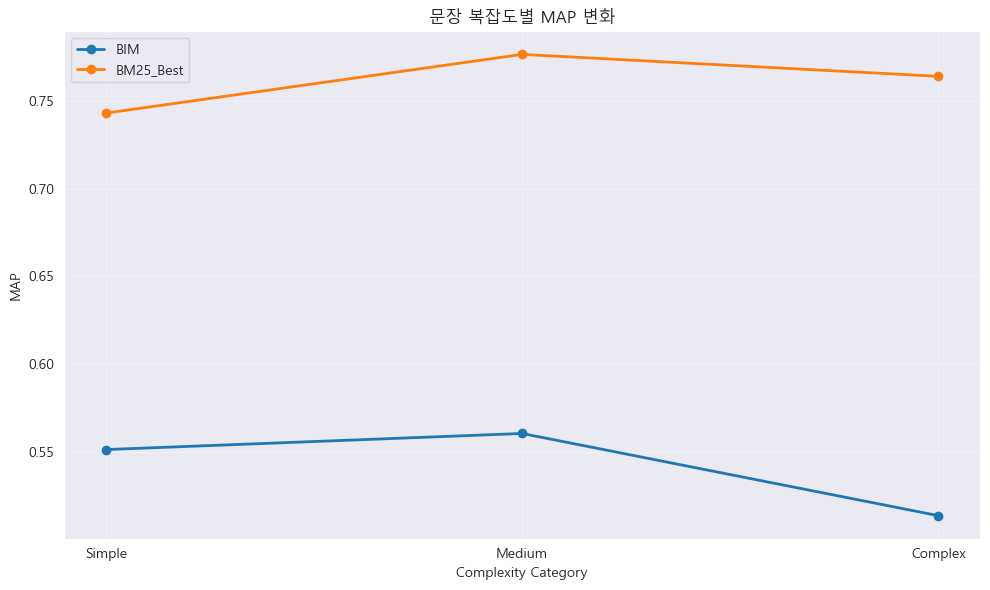

In [7]:
print("\n[시각화 생성]")

plt.figure(figsize=(14, 5))

# 1. 길이별 검색 성능 (Bar Chart)
plt.subplot(1, 3, 1)
df_length_pivot = df_length.pivot(index='category', columns='model', values='MAP')
x = np.arange(len(df_length_pivot))
width = 0.35
plt.bar(x - width/2, df_length_pivot['BIM'], width, label='BIM', alpha=0.8)
plt.bar(x + width/2, df_length_pivot['BM25_Best'], width, label='BM25_Best', alpha=0.8)
plt.xlabel('Length Category')
plt.ylabel('MAP')
plt.title('길이별 검색 성능 (MAP)')
plt.xticks(x, df_length_pivot.index)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 2. 토픽별 검색 성능 (Bar Chart)
plt.subplot(1, 3, 2)
df_topic_pivot = df_topic.pivot(index='topic', columns='model', values='MAP')
x = np.arange(len(df_topic_pivot))
plt.bar(x - width/2, df_topic_pivot['BIM'], width, label='BIM', alpha=0.8)
plt.bar(x + width/2, df_topic_pivot['BM25_Best'], width, label='BM25_Best', alpha=0.8)
plt.xlabel('Topic ID')
plt.ylabel('MAP')
plt.title('토픽별 검색 성능 (MAP)')
plt.xticks(x, df_topic_pivot.index)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 3. 복잡도별 검색 성능 (Bar Chart)
plt.subplot(1, 3, 3)
df_complexity_pivot = df_complexity.pivot(index='complexity', columns='model', values='MAP')
x = np.arange(len(df_complexity_pivot))
plt.bar(x - width/2, df_complexity_pivot['BIM'], width, label='BIM', alpha=0.8)
plt.bar(x + width/2, df_complexity_pivot['BM25_Best'], width, label='BM25_Best', alpha=0.8)
plt.xlabel('Complexity Category')
plt.ylabel('MAP')
plt.title('복잡도별 검색 성능 (MAP)')
plt.xticks(x, df_complexity_pivot.index)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'additional_analysis_v3.png'), dpi=300)
plt.show()

# 4. 문서 길이별 MAP 변화 (Line Chart)
plt.figure(figsize=(10, 6))
for model in ['BIM', 'BM25_Best']:
    subset = df_length[df_length['model'] == model]
    plt.plot(subset['category'], subset['MAP'], marker='o', label=model, linewidth=2)
plt.xlabel('Length Category')
plt.ylabel('MAP')
plt.title('문서 길이별 MAP 변화')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'length_map_trend_v3.png'), dpi=300)
plt.show()

# 5. 토픽별 MAP 변화 (Line Chart)
plt.figure(figsize=(12, 6))
for model in ['BIM', 'BM25_Best']:
    subset = df_topic[df_topic['model'] == model]
    plt.plot(subset['topic'], subset['MAP'], marker='o', label=model, linewidth=2)
plt.xlabel('Topic ID')
plt.ylabel('MAP')
plt.title('토픽별 MAP 변화')
plt.xticks(range(10))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'topic_map_trend_v3.png'), dpi=300)
plt.show()

# 6. 문장 복잡도별 MAP 변화 (Line Chart)
plt.figure(figsize=(10, 6))
for model in ['BIM', 'BM25_Best']:
    subset = df_complexity[df_complexity['model'] == model]
    plt.plot(subset['complexity'], subset['MAP'], marker='o', label=model, linewidth=2)
plt.xlabel('Complexity Category')
plt.ylabel('MAP')
plt.title('문장 복잡도별 MAP 변화')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'complexity_map_trend_v3.png'), dpi=300)
plt.show()